In [29]:
from pymongo import MongoClient
from thefuzz import fuzz, process
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from unidecode import unidecode
from scipy.stats import norm

In [2]:
client = MongoClient()
scopus = client["scopus_colombia"]["stage"]
openalex = client["openalexco"]["works"]

In [3]:
openalexdata = list(openalex.find({"doi":{"$ne":None},"title":{"$ne":None}},{"title":1,"doi":1,"publication_year":1,"host_venue":1}))

In [4]:
def parse_string(text):
    text = unidecode(text.lower())
    text = re.sub( r'[\$_\^]','', re.sub(r'\\\w+','',text ))
    return str(text)

def __colav_similarity(title1,title2,journal1,journal2,year1,year2, ratio_thold=90, partial_thold=95,low_thold=80,verbose=0):

    label = False
    
    #Se revisa si los años y las revistas coinciden
    journal_check = False
    if journal1 and journal2:
        if fuzz.partial_ratio(unidecode(journal1.lower()),unidecode(journal2.lower()))>ratio_thold:
            journal_check=True
    year_check=False
    if year1 and year2:
        if year1==year2:
            year_check = True
    
    length_check=False
    if len(title1.split())>3 and len(title2.split())>3:
        length_check=True
        
    #Si son pocas palabras y no hay por lo menos revista o año para revisar, se descarta de uan vez
    if length_check == False and (journal_check == False or year_check == False):
        return label
    
    if verbose==5:
        if journal_check: print("Journals are the same")
        if year_check: print("Years are the same")
    
    ratio = fuzz.ratio(title1, title2)
    if verbose==5: print("Initial ratio: ",ratio)
    if ratio > ratio_thold and length_check: #Comparación "directa"
        label = True
    if label == False:
        #Comparaciones cuando el título viene en varios idiomas
        title1_list=title1.split("[")
        title2_list=title2.split("[")
        if min([len(item) for item in title1_list]) > 10 and min([len(item) for item in title2_list]) > 10:
            for title in title1_list:
                tmp_title,ratio=process.extractOne(title,title2_list,scorer=fuzz.ratio)
                if ratio > ratio_thold:
                    label=True
                    break
            #if verbose==5: print("ratio over list: ",ratio)
            if label==False:
                for title in title1_list:
                    tmp_title,ratio=process.extractOne(title,title2_list,scorer=fuzz.partial_ratio)
                    if ratio > partial_thold:
                        label=True
                        break
                    elif ratio > low_thold:
                        if journal_check and year_check:
                            label=True
                            break
                #if verbose==5: print("partial ratio over list: ",ratio)
    
    #Partial ratio section
    if label == False:
        ratio = fuzz.partial_ratio(title1, title2) #Cuando la comparación "directa" falla, relajamos el scorer
        #if verbose==5: print("partial ratio: ",ratio)
                
        if ratio > partial_thold and length_check: #si el score supera el umbral (que debería ser mayor al umbral del ratio)
            label=True
        elif ratio > low_thold: #si no lo supera pero sigue siendo un valor alto, revisa el año y la revista
            if journal_check and year_check:
                label=True
             
    return label

def colav_similarity(title1,title2,journal1,journal2,year1,year2,ratio_thold=90, partial_thold=95, low_thold=80,use_regex=True):
    '''
    Compare two papers to know if they are the same or not.

    It uses the title, year and journal names of both papers to compare them in an somewhat elaborated way. Titles are compared using various algorithms of string comparison from thefuzz library with diferent levels of tolerance if its within a range determined by some threshold variables. The years must be the same, though we've seen an erro of +/- one year. Journal names are also compared using thefuzz's algorithms
    
    parameters
    ----------
        title1: str title of one of the papers
        title2: str title of the other paper
        journal1: str name of the journal in which one of the papers was published
        journal2: str name of the journal in which the other paper was published
        year1: int year in which one of the papers was published
        year2: int year in which the other paper was published
        ratio_thold: int threshold to compare through ratio function in thefuzz library
        partial_ratio_thold: int threshold to compare throughpartial_ratio function in thefuzz library
        low_thold: int threshold to discard some results with lower score values
        use_regex: bool Uses a regex to clean the titles
        
    Returns
    -------
    label: bool true when the papers are (potentially) the same.
    '''
    title1 = unidecode(title1.lower())
    title2 = unidecode(title2.lower())
    
    if year1: year1=int(year1)
    if year2: year2=int(year2)
    
    label = False
    
    if not use_regex:
        label = __colav_similarity(title1,title2,journal1,journal2, year1,year2,ratio_thold, partial_thold,low_thold,translation=translate)
    elif use_regex:
        label = __colav_similarity(parse_string(title1), parse_string(title2),journal1,journal2, year1,year2,ratio_thold, partial_thold,low_thold)
    return label

### Balanceo de clases

In [152]:
results=[]
random_print=list(np.random.random(len(openalexdata)))
for i,oa_reg in enumerate(openalexdata):
    if "host_venue" not in oa_reg.keys():
        continue
    if not oa_reg["host_venue"]:
        continue
    if "display_name" not in oa_reg["host_venue"].keys():
        continue
    if not oa_reg["host_venue"]["display_name"]:
        continue
    scopus_reg = list(scopus.find({"$text":{"$search":oa_reg["title"].lower(),"$caseSensitive":False},"DOI":{"$ne":None}}).limit(1))
    if scopus_reg:
        #removing pairs that have the exact same title
        #we do this by removing punctuation, without encoding, lowercase and removing all blank spaces (only for the comparison)
        
        #this has been made since we are not interested in the correctenss of the algorithm
        #when the titles are exactly the same, we have to explore the problematic portions of the problem
        title_oa=re.sub(r'[^\w\s]', '', unidecode(oa_reg["title"]).lower()).replace(" ","")
        titles_scopus=scopus_reg[0]["Title"].replace("]","").split("[")
        #sometimes scopus gives the title with translations enclosed between []
        #so we have to compare the title from openalex to every other scopus translated title
        
        same=False
        for title_scopus in titles_scopus:
            title_scopus=re.sub(r'[^\w\s]', '', unidecode(title_scopus).lower()).replace(" ","")
            if title_oa==title_scopus:
                same=True
                break
        if same:
            if len(titles_scopus)>1 and random_print[i]>0.99:
                print("{}\n\t{}".format(oa_reg["title"],titles_scopus))
        else:
            results.append([oa_reg,scopus_reg[0]])
len(results)

Presentación
	['Presentación ', 'Presentación']
Importancia de la vena cística en la colecistectomía laparoscópica
	['Importance of the cystic vein in laparoscopic cholecystectomy ', 'Importancia de la vena cística en la colecistectomía laparoscópica']
75 lecciones aprendidas en programas de alfabetización informacional en universidades iberoamericanas
	['75 lessons learned from information literacy programs in Ibero-American universities ', '75 lecciones aprendidas en programas de alfabetizacio´n informacional en universidades iberoamericanas']
Espermicida y espermiostático: ¿hacen referencia a lo mismo?
	['Spermicide and spermiostatic: Do they refer to the same thing? ', 'Espermicida y espermiostático: Hacen referencia a lo mismo?']
Is Communication Still Possible Amid the Reign of "Incommunication"?
	['Is communication still possible amid the reign of " incommunication"? ', '¿Es aún posible la comunicación en medio del imperio de la incomunicación?']
Mortalidad por paludismo en Colo

193454

In [153]:
positives=[]
for x,y in results:
    if "DOI" in y.keys():
            if isinstance(y["DOI"],str):
                if x["doi"].replace("https://doi.org/","").lower()==y["DOI"].lower():
                    positives.append([x,y])
negatives=[]
for x,y in results:
    if "DOI" in y.keys():
            if isinstance(y["DOI"],str):
                if x["doi"].replace("https://doi.org/","").lower()!=y["DOI"].lower():
                    negatives.append([x,y])
print(len(positives),len(negatives))

214 140611


In [161]:
positives[10]

[{'_id': ObjectId('637cfba9244b9f9d0fe21955'),
  'doi': 'https://doi.org/10.1007/s10843-015-0162-8',
  'title': 'Is Entrepreneurial Internationalization a field? A bibliometric analysis (1989-2015)',
  'publication_year': 2016,
  'host_venue': {'id': 'https://openalex.org/V175138789',
   'issn_l': '1570-7385',
   'issn': ['1573-7349', '1570-7385'],
   'display_name': 'Journal of International Entrepreneurship',
   'publisher': 'Springer Nature',
   'type': 'publisher',
   'url': 'https://doi.org/10.1007/s10843-015-0162-8',
   'is_oa': False,
   'version': None,
   'license': None}},
 {'_id': ObjectId('5f8637b692dec2f3a4e36831'),
  'Authors': 'Servantie V., Cabrol M., Guieu G., Boissin J.-P.',
  'Author(s) ID': '57160168700;25644304700;27367858900;7006363664;',
  'Title': 'Is international entrepreneurship a field? A bibliometric analysis of the literature (1989–2015) [L’entrepreneuriat international est-il un champ? Une analyse bibliométrique de la littérature (1989–2015)] [¿Es el empr

In [168]:
#2093 140872
def balanced_comparison(oa,scopus,title_comparison="direct",verbose=0):
    '''
    Takes a openalex's register and compares it to a scopus register to report if its the same paper or not.

    It takes an openalex register and finds a match through a text search in Scopus' database with the openalex's title. Then, it compares the titles, years and journals' names (depending on the chosen algorithm) to report its contribution to the confusion matrix

    Parameters
    ----------
        oa_reg: dict OpenAlex register
        title_comparison: an algorithm to compare the two registers (direct, ratio,token_set_ratio, colav)
        verbose: the quantity of messages that the function will print on screen
        
    Returns
    -------
        conf: list The contribution of the comparison to a matrix of confusion
        
    '''
    conf=[0,0,0,0]
    oa_doi = oa["doi"].replace("https://doi.org/","").lower()
    comparison=None
    #if fuzz.ratio(scopus_reg["Title"].lower(),oa_reg["title"].lower())>99:
    if title_comparison=="direct":
        comparison=unidecode(scopus["Title"]).lower()==unidecode(oa["title"]).lower()
    elif title_comparison=="ratio":
        comparison=fuzz.ratio(unidecode(scopus["Title"]).lower(),unidecode(oa["title"]).lower())==100
    elif title_comparison=="token_set_ratio":
        comparison=fuzz.token_set_ratio(unidecode(scopus["Title"]).lower(),unidecode(oa["title"]).lower())==100
    elif title_comparison=="colav":
        comparison=colav_similarity(
            oa["title"],
            scopus["Title"],
            oa["host_venue"]["display_name"].lower(),
            scopus["Source title"].lower(),
            oa["publication_year"],
            scopus["Year"]
        )
    if comparison:
        if oa_doi==scopus["DOI"].lower():
            conf[0]+=1
        else:
            conf[1]+=1
    else:
        if oa_doi==scopus["DOI"].lower():
            conf[3]+=1
        else:
            conf[2]+=1
    return conf

In [177]:
total=200 # each class
chosen_index = np.random.choice(len(positives),total,replace=False)
balanced_set=[x for i,x in enumerate(positives) if i in chosen_index]
chosen_index = np.random.choice(len(negatives),total,replace=False)
balanced_set.extend([x for i,x in enumerate(negatives) if i in chosen_index])
len(balanced_set)

400

In [178]:
%%time
#fuzz token_set_ratio at 100
a=0
conf=[0,0,0,0] # [vp,fp,vn,fn]
result=Parallel(n_jobs=20,backend="threading",verbose=0)(delayed(balanced_comparison)(x,y,"token_set_ratio") for x,y in balanced_set)
for res in result:
    for i in range(len(conf)):
        conf[i]+=res[i]
print(conf,np.sum(conf))
print("TP: {}. \tFN: {}".format(conf[0],conf[-1]))
print("FP: {}. \tTN: {}".format(conf[1],conf[-2]))
acc=(conf[0]+conf[-2])/np.sum(conf)
print("Accuracy: {:.2f}".format(acc))
print("Precision: {:.2f}".format(conf[0]/(conf[0]+conf[1])))
print("Recall: {:.2f}".format(conf[0]/(conf[0]+conf[-1])))

[126, 0, 200, 74] 400
TP: 126. 	FN: 74
FP: 0. 	TN: 200
Accuracy: 0.81
Precision: 1.00
Recall: 0.63
CPU times: user 30.9 ms, sys: 3.96 ms, total: 34.9 ms
Wall time: 37.4 ms


In [179]:
%%time
#fuzz ratio at 100
conf=[0,0,0,0] # [vp,fp,vn,fn]
result=Parallel(n_jobs=20,backend="threading",verbose=0)(delayed(balanced_comparison)(x,y,"ratio") for x,y in balanced_set)
for res in result:
    for i in range(len(conf)):
        conf[i]+=res[i]
print(conf,np.sum(conf))
print("TP: {}. \tFN: {}".format(conf[0],conf[-1]))
print("FP: {}. \tTN: {}".format(conf[1],conf[-2]))
acc=(conf[0]+conf[-2])/np.sum(conf)
print("Accuracy: {:.2f}".format(acc))
print("Precision: {:.2f}".format(conf[0]/(conf[0]+conf[1])))
print("Recall: {:.2f}".format(conf[0]/(conf[0]+conf[-1])))

[13, 0, 200, 187] 400
TP: 13. 	FN: 187
FP: 0. 	TN: 200
Accuracy: 0.53
Precision: 1.00
Recall: 0.07
CPU times: user 35.9 ms, sys: 167 µs, total: 36 ms
Wall time: 41.8 ms


In [180]:
%%time
#colav
conf=[0,0,0,0] # [vp,fp,vn,fn]
result=Parallel(n_jobs=20,backend="threading",verbose=0)(delayed(balanced_comparison)(x,y,"colav") for x,y in balanced_set)
for res in result:
    for i in range(len(conf)):
        conf[i]+=res[i]
print(conf,np.sum(conf))
print("TP: {}. \tFN: {}".format(conf[0],conf[-1]))
print("FP: {}. \tTN: {}".format(conf[1],conf[-2]))
acc=(conf[0]+conf[-2])/np.sum(conf)
print("Accuracy: {:.2f}".format(acc))
print("Precision: {:.2f}".format(conf[0]/(conf[0]+conf[1])))
print("Recall: {:.2f}".format(conf[0]/(conf[0]+conf[-1])))

[183, 1, 199, 17] 400
TP: 183. 	FN: 17
FP: 1. 	TN: 199
Accuracy: 0.95
Precision: 0.99
Recall: 0.92
CPU times: user 44.2 ms, sys: 7.68 ms, total: 51.9 ms
Wall time: 50.2 ms


In [172]:
metrics_list=[[],[],[],[]]
for k in range(200): # 200 repetitions of the experiment
    total=50 # each class
    chosen_index = np.random.choice(len(positives),total,replace=False)
    balanced_set=[x for i,x in enumerate(positives) if i in chosen_index]
    chosen_index = np.random.choice(len(negatives),total,replace=False)
    balanced_set.extend([x for i,x in enumerate(negatives) if i in chosen_index])
    conf=[0,0,0,0] # [vp,fp,vn,fn]
    result=Parallel(n_jobs=20,backend="threading",verbose=0)(delayed(balanced_comparison)(x,y,"colav") for x,y in balanced_set)
    for res in result:
        for i in range(len(conf)):
            conf[i]+=res[i]
    accuracy = (conf[0]+conf[-2])/np.sum(conf)
    metrics_list[0].append(accuracy)
    precision = conf[0]/(conf[0]+conf[1]) 
    metrics_list[1].append(precision)
    recall = conf[0]/(conf[0]+conf[-1])
    metrics_list[2].append(recall)
    f1 = 2*conf[0]/(2*conf[0]+conf[1]+conf[-1])
    metrics_list[3].append(f1)

Mean: 0.954, std: 0.018


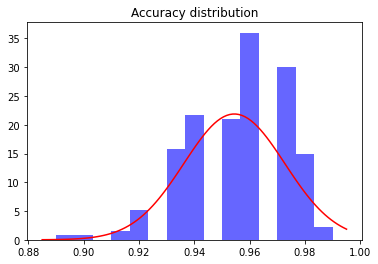

Mean: 0.998, std: 0.008


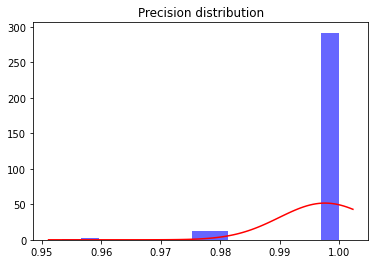

Mean: 0.911, std: 0.035


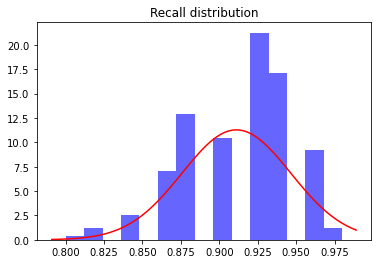

Mean: 0.952, std: 0.020


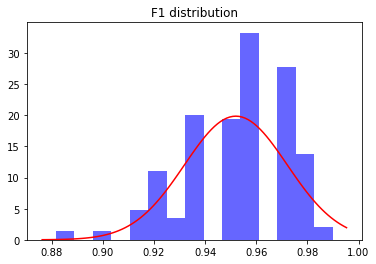

In [173]:
labels = ["Accuracy distribution","Precision distribution","Recall distribution", "F1 distribution"]
for i in range(len(metrics_list)):
    mu,std = norm.fit(metrics_list[i])
    print("Mean: {:.3f}, std: {:.3f}".format(mu,std))
    plt.hist(metrics_list[i],bins=15, density=True,alpha=0.6, color="b")

    xmin,xmax=plt.xlim()
    x=np.linspace(xmin,xmax,100)
    p=norm.pdf(x,mu,std)
    plt.plot(x,p,'r')
    plt.title(labels[i])
    plt.show()